# Dense Retrieval

## Setup

Load needed API keys and relevant Python libaries.

In [ ]:
import os
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

In [ ]:
import cohere
co = cohere.Client('f25TSVZu9ltUtKteb1wmeKRPeSyaAUIEJ91LMa5a')

In [ ]:
import weaviate
auth_config = weaviate.auth.AuthApiKey(
    api_key="76320a90-53d8-42bc-b41d-678647c6672e")

In [ ]:
client = weaviate.Client(
    url="https://cohere-demo.weaviate.network/",
    auth_client_secret=auth_config,
    additional_headers={
        "X-Cohere-Api-Key": "f25TSVZu9ltUtKteb1wmeKRPeSyaAUIEJ91LMa5a"
    }
)
client.is_ready() #check if True

## Part 1: Vector Database for semantic Search

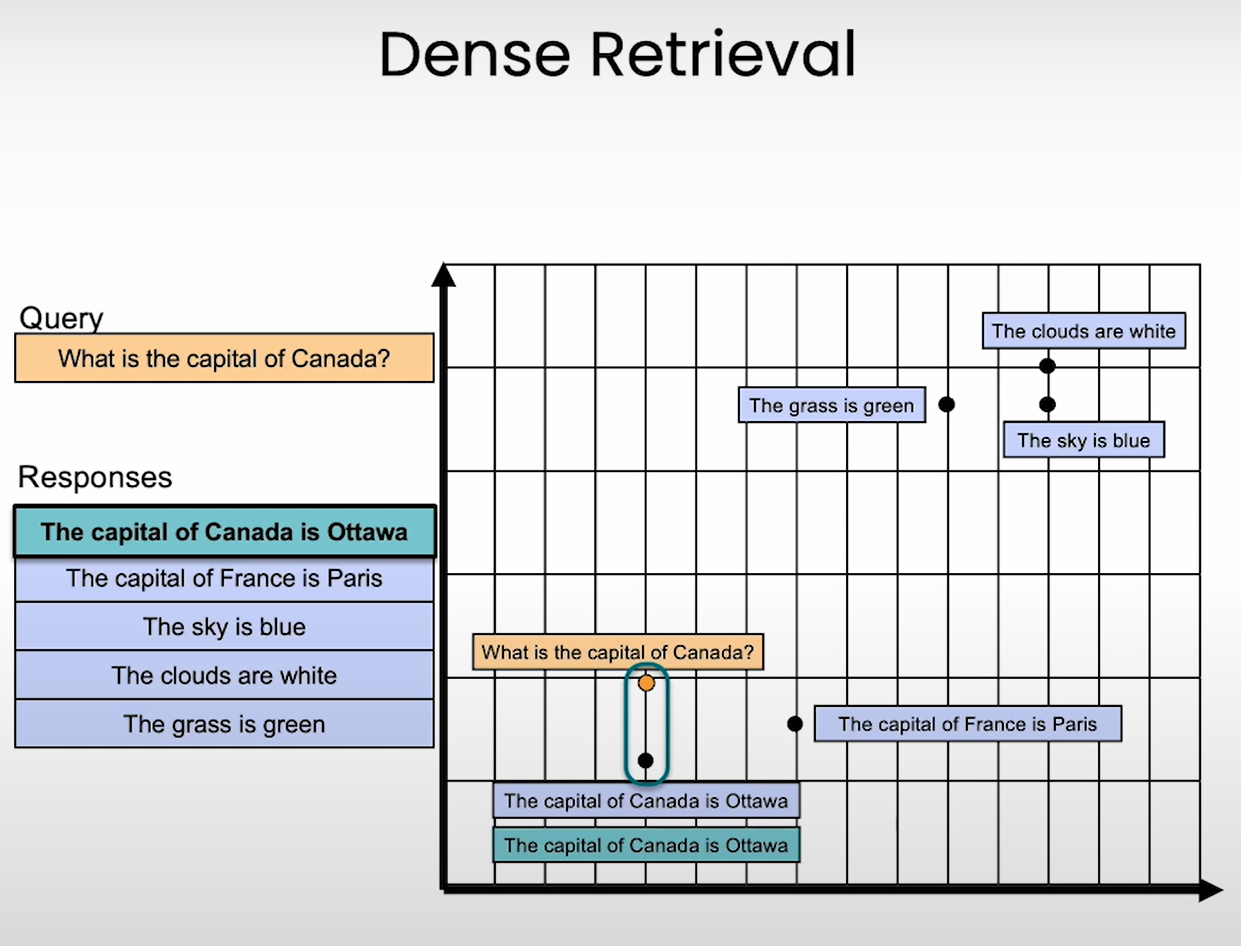

In [ ]:
def dense_retrieval(query, 
                    results_lang='en', 
                    properties = ["text", "title", "url", "views", "lang", "_additional {distance}"],
                    num_results=5):

    nearText = {"concepts": [query]}
    
    # To filter by language
    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }
    response = (
        client.query
        .get("Articles", properties)
        .with_near_text(nearText)
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
    )

    result = response['data']['Get']['Articles']

    return result

In [ ]:

def print_result(result):
    """ Print results with colorful formatting """
    for i,item in enumerate(result):
        print(f'item {i}')
        for key in item.keys():
            print(f"{key}:{item.get(key)}")
            print()
        print()

### Bacic Query

In [ ]:
query = "Who wrote Hamlet?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

### Medium Query

In [ ]:
query = "What is the capital of Canada?"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

Compare it to keyword search

In [ ]:
def keyword_search(query, 
                   client,
                   results_lang='en', 
                   properties = ["title","url","text"],
                   num_results=3):

    where_filter = {
    "path": ["lang"],
    "operator": "Equal",
    "valueString": results_lang
    }

    response = (
        client.query.get("Articles", properties)
        .with_bm25(
          query=query
        )
        .with_where(where_filter)
        .with_limit(num_results)
        .do()
        )
    
    result = response['data']['Get']['Articles']
    return result

In [ ]:
query = "What is the capital of Canada?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)

### Complicated Query

In [ ]:
query = "Tallest person in history?"
keyword_search_results = keyword_search(query, client)
print_result(keyword_search_results)

In [ ]:
query = "Tallest person in history"
dense_retrieval_results = dense_retrieval(query)
print_result(dense_retrieval_results)

## Part 2: Building Semantic Search from Scratch

### Get the text archive:

In [ ]:
from annoy import AnnoyIndex
import numpy as np
import pandas as pd
import re

In [ ]:
text = """
Interstellar is a 2014 epic science fiction film co-written, directed, and produced by Christopher Nolan.
It stars Matthew McConaughey, Anne Hathaway, Jessica Chastain, Bill Irwin, Ellen Burstyn, Matt Damon, and Michael Caine.
Set in a dystopian future where humanity is struggling to survive, the film follows a group of astronauts who travel through a wormhole near Saturn in search of a new home for mankind.

Brothers Christopher and Jonathan Nolan wrote the screenplay, which had its origins in a script Jonathan developed in 2007.
Caltech theoretical physicist and 2017 Nobel laureate in Physics[4] Kip Thorne was an executive producer, acted as a scientific consultant, and wrote a tie-in book, The Science of Interstellar.
Cinematographer Hoyte van Hoytema shot it on 35 mm movie film in the Panavision anamorphic format and IMAX 70 mm.
Principal photography began in late 2013 and took place in Alberta, Iceland, and Los Angeles.
Interstellar uses extensive practical and miniature effects and the company Double Negative created additional digital effects.

Interstellar premiered on October 26, 2014, in Los Angeles.
In the United States, it was first released on film stock, expanding to venues using digital projectors.
The film had a worldwide gross over $677 million (and $773 million with subsequent re-releases), making it the tenth-highest grossing film of 2014.
It received acclaim for its performances, direction, screenplay, musical score, visual effects, ambition, themes, and emotional weight.
It has also received praise from many astronomers for its scientific accuracy and portrayal of theoretical astrophysics. Since its premiere, Interstellar gained a cult following,[5] and now is regarded by many sci-fi experts as one of the best science-fiction films of all time.
Interstellar was nominated for five awards at the 87th Academy Awards, winning Best Visual Effects, and received numerous other accolades"""

### Chunking: 

In [ ]:
# Split into a list of sentences
texts = text.split('.')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [ ]:
texts

In [ ]:
# Split into a list of sentences
texts = text.split('.')

# split into a list of paragraph 
#texts = text.split('\n\n')

# Clean up to remove empty spaces and new lines
texts = np.array([t.strip(' \n') for t in texts])

In [ ]:
texts

add title for each sentence

In [ ]:
title = 'Interstellar (film)'

texts = np.array([f"{title} {t}" for t in texts])

In [ ]:
texts

### Get the embeddings:

In [ ]:
response = co.embed(
    texts=texts.tolist()
).embeddings

In [ ]:
embeds = np.array(response)
embeds.shape

### Create the search index:

In [ ]:
search_index = AnnoyIndex(embeds.shape[1], 'angular')
# Add all the vectors to the search index
for i in range(len(embeds)):
    search_index.add_item(i, embeds[i])

search_index.build(10) # 10 trees
search_index.save('test.ann')

In [1]:
pd.set_option('display.max_colwidth', None)

def search(query):

  # Get the query's embedding
  query_embed = co.embed(texts=[query]).embeddings

  # Retrieve the nearest neighbors
  similar_item_ids = search_index.get_nns_by_vector(query_embed[0],
                                                    3,
                                                  include_distances=True)
  # Format the results
  results = pd.DataFrame(data={'texts': texts[similar_item_ids[0]],
                              'distance': similar_item_ids[1]})
  print(texts[similar_item_ids[0]])
  return results

NameError: name 'pd' is not defined

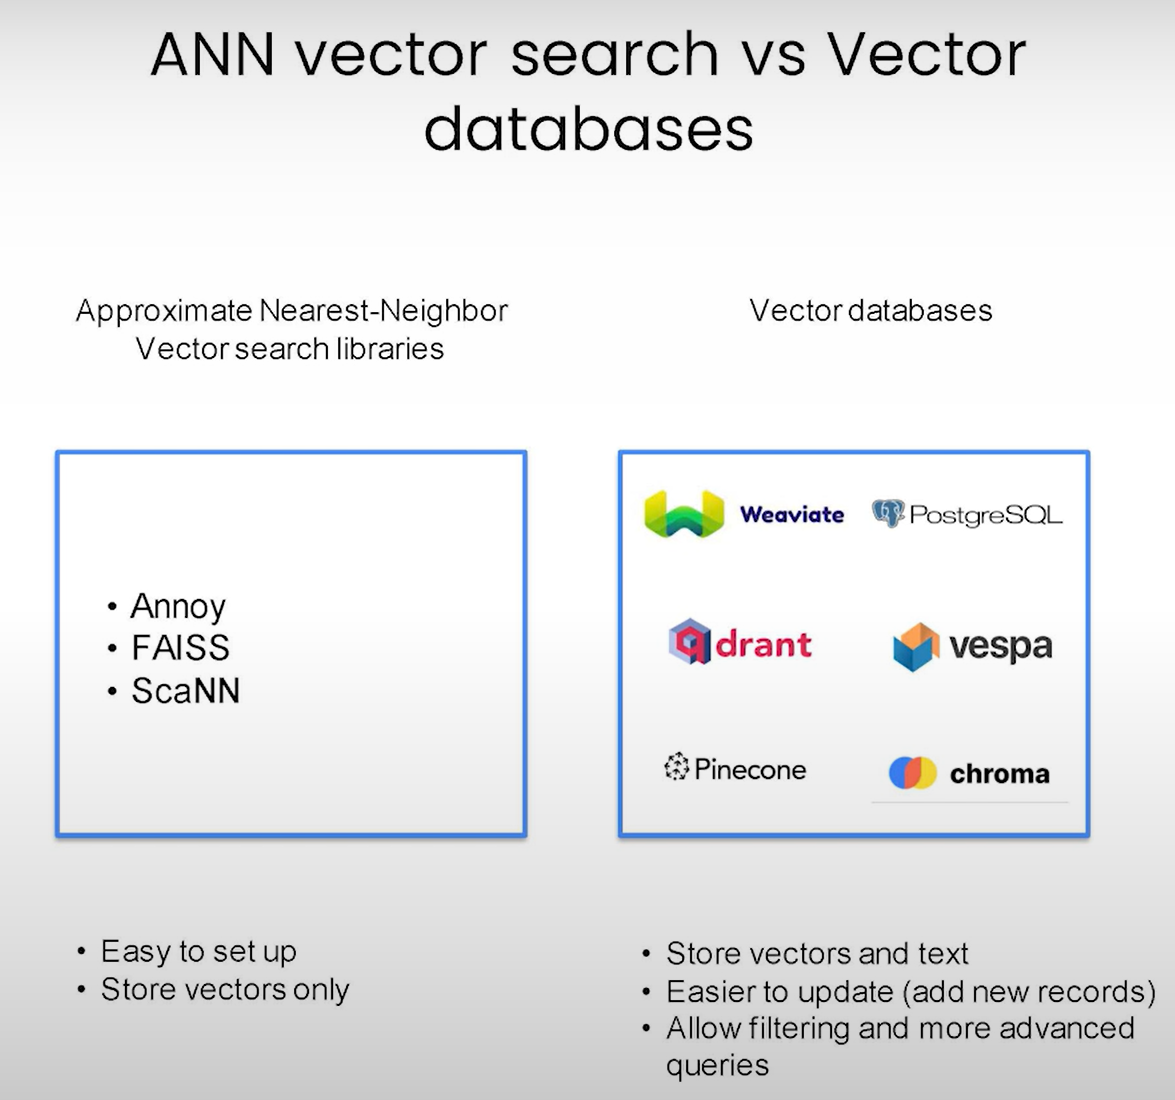

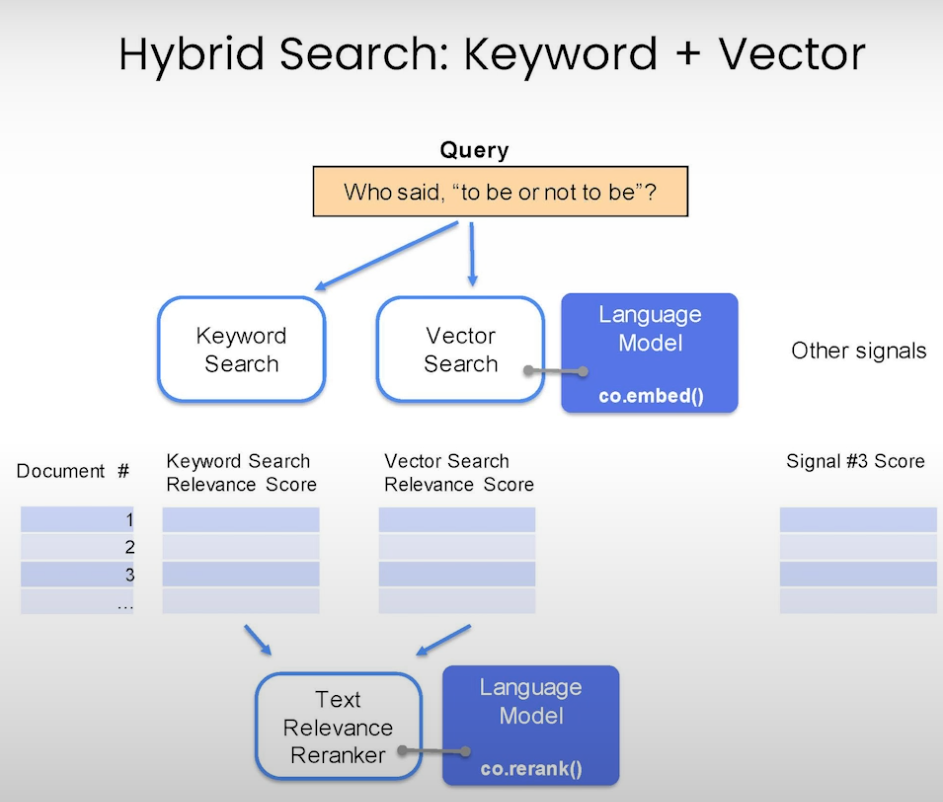

Pretrained Transformers for text Ranking: BERT and Beyond

https://arxiv.org/pdf/2010.06467